## Program transformations

* `jit()`, for speeding up your code
* `grad()`, for taking derivatives
* `vmap()`, for automatic vectorization or batching

## Activation functions

The rationale of using activation functions is to add non-linearity. When we stack linear transformation ($Wx+b$) layers in neural networks, we can add activation functions to add complexity and non-linear relationships in data.

Resource: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

In [96]:
import jax.numpy as jnp
from jax import lax

In [97]:
# Sigmoid (also know as logistic); (0,1)
def sigmoid(z):
  return 1/(1+jnp.exp(-z))

# Tanh; (-1,1)
def tanh(z):
  return jnp.tanh(z)

# ReLU; (0, inf)
def relu(z):
  return jnp.where(z > 0, z, 0)

# Leaky ReLu, an attempt to solve the dying ReLU problem
def lrelu(z, alpha=0.01):
  return jnp.where(z > 0, z, alpha*z)

# SeLU
def selu(z, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(z > 0, z, alpha*jnp.exp(z) - alpha)

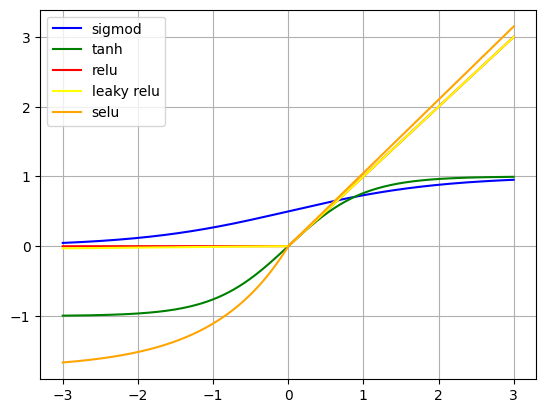

In [98]:
from jax import random
import matplotlib.pyplot as plt

x = jnp.linspace(-3,3,10000)
sigmoid_x = sigmoid(x)
tanh_x = tanh(x)
relu_x = relu(x)
lrelu_x = lrelu(x)
selu_x = selu(x)

plt.plot(x, sigmoid_x, label="sigmod", color="blue")
plt.plot(x, tanh_x, label="tanh", color="green")
plt.plot(x, relu_x, label="relu", color="red")
plt.plot(x, lrelu_x, label="leaky relu", color="yellow")
plt.plot(x, selu_x, label="selu", color="orange")
plt.grid(True)
plt.legend()
plt.show()

## Taking derivatives - autodiff



In [99]:
# jnp.eye returns a 2D array with 1 in a diagonal element and 0 elsewhere
for i in jnp.eye(3):
  print(i)

[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [100]:
from jax import grad

def sum_logistic(x):
  return jnp.sum(1. / (1. + jnp.exp(-x)))

x = jnp.arange(3.)
print(f'x: {x}')
derivative_fn = grad(sum_logistic)
print(f'f\'(x): {derivative_fn(x)}')

x: [0. 1. 2.]
f'(x): [0.25       0.19661194 0.10499357]


In [101]:
1e-3

0.001

In [102]:
# finite differences: (f(x+h) - f(x-h))/2h

def first_finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x+eps*v) - f(x-eps*v))/(2*eps) for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x))

[0.24998187 0.1965761  0.10502338]


## Jacobian and Hessian

Jacobian of a function $f(x_1, x_2, x_3, ..)$ can be thought of as a vector where each element is a partial derivative of $f$ with respect to each one of its variables.

$$
J = [\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \frac{\partial f}{\partial x_3}, ...]
$$


The Hessian matrix is similar to Jacobian but now we collect the second derivatives.


$$
H =
\left(\begin{array}{cc}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1x_2}\\
\frac{\partial^2 f}{\partial x_2x_1} & \frac{\partial^2 f}{\partial x_2^2}
\end{array}\right)
$$



> Why do we need the Hessian matrix?

When we train neural networks, neural networks use backpropagation to update parameters. Backpropagation is based on gradient descent and gradient descent is an optimization algorithm to find a global maximum/minimum. The Hessian matrix helps determine whether the function being optimized with gradient descent is a convex thus having a local/global minimum.

* The function f has a local minimum if $f_{xx}(a, b)$ > 0 and the $D(a,b)$ > 0
* The function f has a local maximum if $f_{xx}(a, b)$ < 0 and the $D(a,b)$ > 0
* The function f has a saddle point if $D(a, b)$ < 0
* We cannot draw any conclusions if $D(a, b)$ = 0 and need more tests

In [103]:
from jax import jacfwd, jacrev, jit # reverse-mode vector-Jacobian products and forward-mode Jacobian-vector products
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

# I'm slightly confused how jacfwd and jacrev work

In [104]:
def ex_fn(x, y):
  return x**2 + x*y # in Python, ^ is an XOR operator, not squaring

jacrev(ex_fn)(2.,3.) # partial_x: 2x + y = 2*2 + 3 = 7

Array(7., dtype=float32, weak_type=True)

In [105]:
jacfwd(ex_fn)(2.,3.) # partial_x

Array(7., dtype=float32, weak_type=True)

In [106]:
jacfwd(jacrev(ex_fn))(2.,3.)

Array(2., dtype=float32, weak_type=True)

In [107]:
jacrev(jacfwd(ex_fn))(2.,3.)

Array(2., dtype=float32, weak_type=True)

In [108]:
jacfwd(jacfwd(ex_fn))(2.,3.)

Array(2., dtype=float32, weak_type=True)

## Auto-vectorization - `vmap()`

I found a good example of `vmap` [here](https://iwasnothing.medium.com/playing-with-jax-vmap-e6d0d1a59dda). Upgrading from calculating moving average in the link's example, let's try to calculate the average pixels as the kernel moves through the matrix in both numpy and JAX.

In [109]:
import numpy as np

sample_mat = np.random.randint(low=1, high=10, size=(5, 5))
sample_mat

array([[1, 4, 9, 2, 9],
       [7, 3, 6, 1, 6],
       [2, 8, 1, 5, 6],
       [9, 3, 5, 4, 3],
       [7, 1, 6, 6, 9]])

In [110]:
import numpy as np

def kernel_loop(mat, k_size):
  v = mat.shape[0]
  avg_mat = np.zeros((v-k_size+1, v-k_size+1))
  for i in range(v-k_size+1):
    for j in range(k_size-1,v):
        m_val = np.mean(mat[i:i+k_size, j-k_size+1:j+1])
        avg_mat[i,j-k_size+1] = m_val
  return avg_mat

kernel_loop(sample_mat, 3)

array([[4.55555556, 4.33333333, 5.        ],
       [4.88888889, 4.        , 4.11111111],
       [4.66666667, 4.33333333, 5.        ]])

In JAX, as values are immutable, we can't update `avg_mat`.

In [122]:
lax.dynamic_slice(jnp.array(sample_mat), (2,2), (4,4))

Array([[3, 6, 1, 6],
       [8, 1, 5, 6],
       [3, 5, 4, 3],
       [1, 6, 6, 9]], dtype=int32)

In [128]:
from jax import vmap

def kernel_avg(mat, k_size, i, j):
  sub_mat = lax.dynamic_slice(mat, (i, j-k_size+1), (k_size, k_size))
  return np.mean(sub_mat)

kernel_avg_map = vmap(vmap(kernel_avg, (None, None, None, 0), 0), (None, None, 0, None), 0)
print(kernel_avg_map(jnp.array(sample_mat), 3, jnp.arange(0,3), jnp.arange(2,5)))

[[4.555556  4.3333335 5.       ]
 [4.888889  4.        4.111111 ]
 [4.6666665 4.3333335 5.       ]]


## Pseudorandom Number Generators (PRNGs)

`numpy` uses the **Mersenne Twister** PRNG which is known to have a number of problems and to be slow. JAX implements a modern **Threefry counter-based PRNG** that's splittable.

> Don't resuse the same state but instead split the PRNG to get usable subkeys every time we need a new generated number.

In [112]:
from jax import random
key = random.PRNGKey(0); key # PRNG state

Array([0, 0], dtype=uint32)

In [113]:
x = random.normal(key, (10,)); x

Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
       -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32)

In [114]:
# DON'T REUSE THE SAME STATE
random.normal(key, (10,))

Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
       -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32)

In [115]:
key, subkey = random.split(key); [key, subkey]

[Array([4146024105,  967050713], dtype=uint32),
 Array([2718843009, 1272950319], dtype=uint32)]

In [116]:
random.normal(subkey, shape=(1,))

Array([-1.2515389], dtype=float32)

In [117]:
# Keep splitting the key whenever we need a new random number
key, subkey = random.split(key); [key, subkey]

[Array([2384771982, 3928867769], dtype=uint32),
 Array([1278412471, 2182328957], dtype=uint32)]

## Updating elements in JAX


In [129]:
x = jnp.arange(10)
# x[0] = 10 doesn't work
x.at[0].set(10)

Array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32)

## max/min - `jnp.min/max()` & `lax.min/max()`

* jnp.max() is used to get axis-wise max
* lax.max() is used to get element-wise max

In [140]:
key = random.PRNGKey(0)
a = random.randint(key,(5,),minval=1,maxval=10); a

Array([5, 2, 1, 3, 4], dtype=int32)

In [144]:
# axis-wise
print(jnp.max(a))

# element-wise
# lax.max(a) doesn't work
b = random.randint(key, (5,), minval=3, maxval=10); b

5


Array([9, 7, 5, 4, 4], dtype=int32)

In [145]:
lax.max(a,b)

Array([9, 7, 5, 4, 4], dtype=int32)

## numpy & lax


In [148]:
# convolution is a sum of element-wise products as a kernel (the first argument) moves

x = jnp.array([1,2,3])
y = jnp.ones(10)
jnp.convolve(x,y) # the overlapping part's slightly confusing, after the match's end, the list moves not the kernel?

Array([1., 3., 6., 6., 6., 6., 6., 6., 6., 6., 5., 3.], dtype=float32)

## lax.conv_general_dilated